# Working with automated computations: Imported tables
# Application to Calcium Imaging

Welcome back! The practical example of this session is calcium imaging! 

![pipeline](../images/pipeline-calcium-imaging.svg)

During this session you will learn:

* To import neuron imaging data from data files into an `Imported` table
* To automatically trigger data importing and computations for all the missing entries with `Populate`

## Importing libraries

First thing first, let's import `DataJoint` again.

In [1]:
import datajoint as dj

As we are going to perform some computations, let's go ahead and import `NumPy` and `Matplotlib`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Calcium imaging dataset

In the `data` folder in this `DataJoint-Tutorials`, you can find a small dataset of three different cases of calcium imaging scans: `example_scan_02.tif`, `example_scan_03.tif`and `example_scan_01.tif`.

As you might know, calcium imaging scans (raw data) are stored as *.tif* files. 

*NOTE: For this tutorial there is no need to deeper explore this small dataset. Nevertheless, if you are curious about visualizing these example scans, we recommend you to open the TIFF with [ImageJ](https://imagej.nih.gov/ij/download.html).*

## First steps of the pipeline design: Schema, Mouse & Session

The DataJoint pipeline commonly starts with a `schema` and the following classes for each table: `Mouse` and `Session`. Let's quickly create this pipeline's first steps as we learned it in the previous session:

In [3]:
schema = dj.schema("tutorial")


@schema
class Mouse(dj.Manual):
    definition = """
    # Experimental animals
    mouse_id             : int                          # Unique animal ID
    ---
    dob=null             : date                         # date of birth
    sex="unknown"        : enum('M','F','unknown')      # sex
    """


@schema
class Session(dj.Manual):
    definition = """
    # Experiment session
    -> Mouse
    session_date               : date                         # date
    ---
    experiment_setup           : int                          # experiment setup ID
    experimenter               : varchar(100)                 # experimenter name
    data_path=''               : varchar(255)                 # relative path
    """


mouse_data = [
    {"dob": "2017-03-01", "mouse_id": 0, "sex": "M"},
    {"dob": "2016-11-19", "mouse_id": 1, "sex": "M"},
    {"dob": "2016-11-20", "mouse_id": 2, "sex": "unknown"},
    {"dob": "2016-12-25", "mouse_id": 5, "sex": "F"},
    {"dob": "2017-01-01", "mouse_id": 10, "sex": "F"},
    {"dob": "2017-01-03", "mouse_id": 11, "sex": "F"},
    {"dob": "2017-05-12", "mouse_id": 100, "sex": "F"},
]

session_data = [
    {
        "experiment_setup": 0,
        "experimenter": "Edgar Y. Walker",
        "mouse_id": 0,
        "session_date": "2017-05-15",
        "data_path": "../data/",
    },
    {
        "experiment_setup": 0,
        "experimenter": "Edgar Y. Walker",
        "mouse_id": 0,
        "session_date": "2017-05-19",
        "data_path": "../data/",
    },
    {
        "experiment_setup": 1,
        "experimenter": "Fabian Sinz",
        "mouse_id": 5,
        "session_date": "2017-01-05",
        "data_path": "../data/",
    },
    {
        "experiment_setup": 100,
        "experimenter": "Jacob Reimer",
        "mouse_id": 100,
        "session_date": "2017-05-25",
        "data_path": "../data/",
    },
]

Mouse.insert(mouse_data, skip_duplicates=True)
Session.insert(session_data, skip_duplicates=True)

[2025-01-02 15:55:54,143][INFO]: Connecting root@db:3306
[2025-01-02 15:55:54,152][INFO]: Connected root@db:3306


Take a quick look at the tables `Mouse` and `Session`:

In [4]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex
0,2017-03-01,M
1,2016-11-19,M
2,2016-11-20,unknown
5,2016-12-25,F
10,2017-01-01,F
11,2017-01-03,F
100,2017-05-12,F


In [5]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path relative path
0,2017-05-15,0,Edgar Y. Walker,../data/
0,2017-05-19,0,Edgar Y. Walker,../data/
5,2017-01-05,1,Fabian Sinz,../data/
100,2017-05-25,100,Jacob Reimer,../data/


## Define the Scan table and its primary key attributes

First we define a table named `Scan` that describes a scanning in an experimental session of Calcium Imaging. This table will store the scans' metadata.

In [7]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_idx    : int           # scan index
    ---
    depth       : float         # depth of this scan
    wavelength  : float         # wavelength used
    laser_power : float         # power of the laser used
    fps         : float         # frames per second
    file_name    : varchar(128) # name of the tif file
    """

The table `Scan` is dependent on the table `Session`, inheriting its primary key attributes. In addition, `Scan` has an additional primary key attribute `scan_idx`. 

One session might contain multiple scans - This is another example of **one-to-many** relationship. 

Take a look at the `dj.Diagram` again:

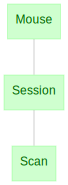

In [8]:
dj.Diagram(schema)

The thin solid line connecting [`Mouse`-`Session`] and [`Session`-`Scan`] indicates **one-to-many relationship**.  

The underline `____` indicates **additional primary key attribute(s)** apart from the ones inherited from its parents.

In [9]:
Scan()

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file


Now we manually `insert` the metadata of the datasets and their file names in the table `Scan`:

In [10]:
Scan.insert(
    [
        {
            "mouse_id": 0,
            "session_date": "2017-05-15",
            "scan_idx": 1,
            "depth": 150,
            "wavelength": 920,
            "laser_power": 26,
            "fps": 15,
            "file_name": "example_scan_01.tif",
        },
        {
            "mouse_id": 0,
            "session_date": "2017-05-15",
            "scan_idx": 2,
            "depth": 200,
            "wavelength": 920,
            "laser_power": 24,
            "fps": 15,
            "file_name": "example_scan_02.tif",
        },
        {
            "mouse_id": 0,
            "session_date": "2017-05-15",
            "scan_idx": 3,
            "depth": 200,
            "wavelength": 920,
            "laser_power": 24,
            "fps": 15,
            "file_name": "example_scan_03.tif",
        },
    ]
)

In [11]:
Scan()

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2017-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2017-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
0,2017-05-15,3,200.0,920.0,24.0,15.0,example_scan_03.tif


### Calculation of the average frame

Let's first load and look at the number of frames of the calcium imaging TIF files:

In [12]:
import os
from skimage import io

im = io.imread("../data/example_scan_01.tif")
print("Number of frames = ", im.shape[0])

Number of frames =  100


Particularly, this example contains 100 frames. 

Let's calculate the average of the images over the frames and plot the result.


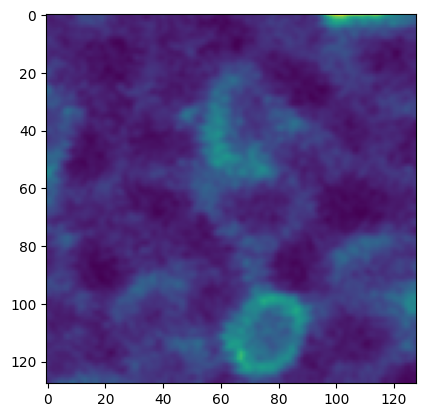

In [13]:
# ENTER YOUR CODE!
av_frame = np.mean(im, axis=0)
plt.imshow(av_frame)

*TIP: compute the `average frame` of the `im` image using the mean function from NumPy (np.mean) with axis = 0. Then, plot the result with `imshow`*

## Define the table for the average fluorescence 

Now let's create a table `AverageFrame` to compute and save the average fluorescence across the frames. 

For each scan, we have one average frame. Therefore, the table shares the exact same primary key as the table `Scan`

In [14]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """

Let's check the state of our pipeline.

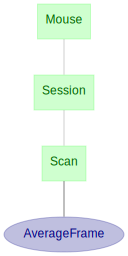

In [15]:
dj.Diagram(schema)

Note that `AverageFrame` and `Scan` share the exact same primary key attributes, so `Scan` and `AverageFrame` have a **one-to-one** relationship, which is indicated with a thick solid line.

We defined `average_frame` as a `longblob`, which allow us to store a NumPy array. This NumPy array will be imported and computed from the file corresponding to each scan.

Note that our `AverageFrame` class inherits from `dj.Imported` instead of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## DataJoint table tiers

In DataJoint, the tier of the table indicates **the nature of the data and the data source for the table**. So far we have encountered two table tiers: `Manual` and `Imported`, and we will encounter the two other major tiers in this session. 

DataJoint tables in `Manual` tier, or simply **Manual tables** indicate that its contents are **manually** entered by either experimenters or a recording system, and its content **do not depend on external data files or other tables**. This is the most basic table type you will encounter, especially as the tables at the beginning of the pipeline. In the diagram, `Manual` tables are depicted by green rectangles.

On the other hand, **Imported tables** are understood to pull data (or *import* data) from external data files, and come equipped with functionalities to perform this importing process automatically, as we will see shortly! In the Diagram, `Imported` tables are depicted by blue ellipses.

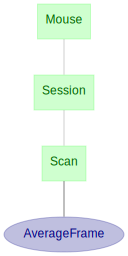

In [16]:
dj.Diagram(schema)

## Importing data into the `Imported` table

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic that comes with `Imported` tables. These two methods automatically figure it out what needs to be imported, and perform the import.

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's call it for `AverageFrame`:

*Note that the following code line is intended to generate a code error.*

In [17]:
AverageFrame.populate()

NotImplementedError: Subclasses of AutoPopulate must implement the method `make`

Notice that the `populate` call complained that a method called `make` is not implemented. Let me show you a simple `make` method that will help elucidate what this is all about.

In [18]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """

    def make(
        self, key
    ):  # key is the primary key of one of the entries in the table `Scan`
        print("key is", key)

Now, let's call `populate` again!

In [19]:
# ENTER YOUR CODE! - call `populate` on the table AverageFrame
AverageFrame.populate()

key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 1}
key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 2}
key is {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 3}


{'success_count': 3, 'error_list': []}

When you call `populate` on an `Imported` table, this triggers DataJoint to look up all tables that the `Imported` table depends on.

For **every unique combination of entries in the depended or "parent" tables**, DataJoint calls `make` function, passing in the primary key of the parent(s).

Because `AverageFrame` depends on `Scan`, `AverageFrame`'s `make` method was called for each entry of `Scan`

In [20]:
Scan()

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2017-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2017-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
0,2017-05-15,3,200.0,920.0,24.0,15.0,example_scan_03.tif


In [21]:
AverageFrame()

mouse_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames


Note that `make` only receives the *primary key attributes* of `Scan` (`mouse_id`, `session_date`, `scan_idx`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [22]:
import os


@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """

    def make(
        self, key
    ):  # key is the primary key of one of the entries in the table `Scan`
        # fetch data directory from table Session
        data_path = (Session & key).fetch1("data_path")

        # fetch data file name from table Scan
        file_name = (Scan & key).fetch1("file_name")

        # load the file
        im = io.imread(os.path.join(data_path, file_name))
        # compute the average image across the frames
        avg_image = np.mean(im, axis=0)

        # Now prepare the entry as a dictionary with all fields defined in the table.
        key["average_frame"] = avg_image  # inherit the primary key from the table Scan

        # insert entry with the method `insert1()`
        self.insert1(key)

        print("\tPopulated Scan {mouse_id} - {session_date} - {scan_idx}".format(**key))

Notice that we added the missing attribute information `average_frame` into the `key` dictionary, and finally **inserted the entry** into `self` (in this case, `self` corresponds to the `AverageFrame` table). The `make` method's job is to create and insert a new entry. This new entry corresponds to the `key` into this table.

Finally, let's go ahead and call `populate` to actually populate the `AverageFrame` table with the new content, i.e. filling the table with the data loaded and computed from data files!

In [23]:
AverageFrame.populate()

	Populated Scan 0 - 2017-05-15 - 1
	Populated Scan 0 - 2017-05-15 - 2
	Populated Scan 0 - 2017-05-15 - 3


{'success_count': 3, 'error_list': []}

Let's take a look at the table now.

In [24]:
AverageFrame()

mouse_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2017-05-15,1,=BLOB=
0,2017-05-15,2,=BLOB=
0,2017-05-15,3,=BLOB=


What happens if we call `AverageFrame.populate` again?

In [25]:
AverageFrame.populate()

{'success_count': 0, 'error_list': []}

That's right - nothing! This makes sense, because we have computed `AverageFrame` for all entries in `Scan` and nothing is left to be computed.

Now what happens if we insert a new entry into `Scan`?

In [26]:
Scan.insert1(
    {
        "mouse_id": 100,
        "session_date": "2017-05-25",
        "scan_idx": 1,
        "depth": 150,
        "wavelength": 920,
        "laser_power": 25,
        "fps": 15,
        "file_name": "example_scan_03.tif",
    }
)

We can find all the `Scan` entries without their corresponding `AverageFrame` entries using the **negative restriction operator** `-`

In [27]:
# select all the `Scan` entries *without* a corresponding entry in `AverageFrame`
Scan - AverageFrame

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
100,2017-05-25,1,150.0,920.0,25.0,15.0,example_scan_03.tif


In [28]:
AverageFrame.populate()

	Populated Scan 100 - 2017-05-25 - 1


{'success_count': 1, 'error_list': []}

`populate` found the uncomputed entry and processed it!

In [29]:
AverageFrame()

mouse_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2017-05-15,1,=BLOB=
0,2017-05-15,2,=BLOB=
0,2017-05-15,3,=BLOB=
100,2017-05-25,1,=BLOB=


Now instead of loading from the raw *.tif* file, we are able to fetch the average fluorescence image from this table.

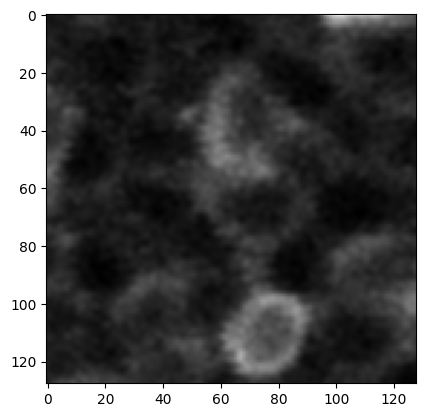

In [30]:
key = dict(mouse_id=0, session_date="2017-05-15", scan_idx=1)
avg_image = (AverageFrame & key).fetch1("average_frame")
plt.imshow(avg_image, cmap=plt.cm.gray)

## Summary

Congratulations! You have successfully:
- Extended your pipeline with a new table to represent the processed data (`AverageFrame` as `Imported` table)
- Learned and implemented the `make()` and `populate()` calls to load the external data to your tables

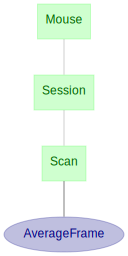

In [31]:
dj.Diagram(schema)

At this point, our pipeline contains the core elements with the data populated, ready for further downstream analysis.

In the next session `03-Calcium Imaging Computed Tables`:
- We will introduce the concept of `Computed` table and `Lookup` table
- We will also set up an automated computation routine, essential to develop advanced data analyses in your experiments!